In [1]:
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch


In [2]:
baseDir='/hdfs/user/ys20884/hackathon/data'
dataset = Dataset(1_000, (120, 72), signal_file=f"{baseDir}/CaloImages_signal.root", pile_up_file=f"{baseDir}/CaloImages_bkg.root", save=False)

In [3]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
100%|██████████| 1000/1000 [00:01<00:00, 645.27it/s]
INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
100%|██████████| 1000/1000 [00:01<00:00, 636.51it/s]


In [4]:
new_dim=(64,64)

In [5]:
dataset.preprocess(16, new_dim)

INFO:root:scaling
scaling


INFO:root:re-sizing
re-sizing


In [6]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [7]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)

In [8]:
noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([1]) #each unit of timestep represents an addtional 5 pile-up events
random_seed = 42
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[0], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)


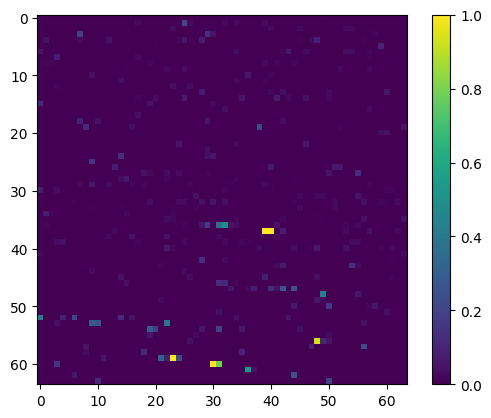

In [9]:
plt.imshow(noisy_image.reshape(new_dim))
plt.colorbar()

In [10]:
from models import Model

model = Model('UNet', new_dim)

In [11]:
model = model.__getitem__()

In [12]:
trained_model_path = '/hdfs/user/ys20884/hackathon/trained_models/trained_diffusor.pt'

In [13]:
checkpoint = torch.load(trained_model_path)

In [14]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [15]:
noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0]

In [16]:
de_noised = noisy_image[0] - (noise_pred.detach().numpy().reshape(new_dim))

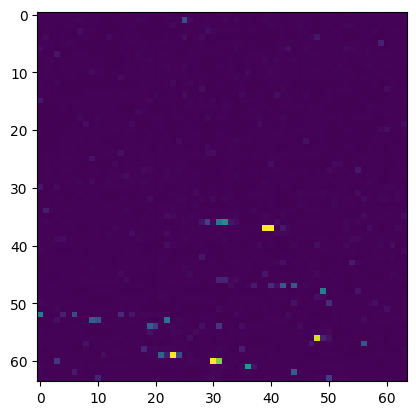

In [17]:
plt.imshow(de_noised.reshape(new_dim))